In [1]:
import torch
import torchvision.models as models
import numpy as np
import pandas as pd
# Example: Using ResNet50 as the CNN backbone
backbone = models.resnet50(pretrained=True)
# Replace the final fully connected layer with an identity transform
backbone.fc = torch.nn.Identity()

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 193MB/s]


In [2]:
class ProjectionHead(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=512, output_dim=128):
        super(ProjectionHead, self).__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x

# Example: Creating a projection head
# Assuming the output features of your backbone has 2048 dimensions
projection_head = ProjectionHead(input_dim=2048)


In [3]:
class NTXentLoss(torch.nn.Module):
    def __init__(self, temperature, device):
        super(NTXentLoss, self).__init__()
        self.temperature = temperature
        self.device = device
        self.criterion = torch.nn.CrossEntropyLoss().to(device)

    def forward(self, z_i, z_j):
        N, Z = z_i.size()  # Batch size and feature dimension

        # Concatenate the positive pairs
        z = torch.cat((z_i, z_j), dim=0)

        # Calculate cosine similarity
        sim = torch.mm(z, z.T) / self.temperature
        sim_i_j = torch.diag(sim, N)
        sim_j_i = torch.diag(sim, -N)

        # Create positive and negative masks
        positive_mask = torch.cat((sim_j_i, sim_i_j), dim=0).reshape(2 * N, 1)
        negative_mask = sim > -1e6  # Mask to remove self-similarity

        labels = torch.from_numpy(np.array([range(N), range(N)])).view(2 * N).to(self.device)
        loss = self.criterion(sim, labels)

        return loss

# Example: Creating the NT-Xent Loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
contrastive_loss = NTXentLoss(temperature=0.5, device=device)


In [4]:
class SimCLR(torch.nn.Module):
    def __init__(self, backbone, projection_head):
        super(SimCLR, self).__init__()
        self.backbone = backbone
        self.projection_head = projection_head

    def forward(self, x_i, x_j):
        h_i = self.backbone(x_i)
        h_j = self.backbone(x_j)

        z_i = self.projection_head(h_i)
        z_j = self.projection_head(h_j)

        return z_i, z_j

# Instantiate the SimCLR model
simclr_model = SimCLR(backbone, projection_head)


In [5]:
# Add a linear layer for classification (after training SimCLR model)
class Classifier(torch.nn.Module):
    def __init__(self, feature_dim, num_classes):
        super(Classifier, self).__init__()
        self.fc = torch.nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        x = self.fc(x)
        return x


num_classes = 10  # Set the number of classes in UrbanSound8K
feature_dim= 2048
classifier = Classifier(feature_dim, num_classes).to(device)

In [10]:
import torchvision.transforms as transforms

def get_simclr_transformations(size, s=1):
    """Return a set of data transformations for SimCLR.

    Args:
    - size (int): Size of the square crop.
    - s (float): Strength of color jitter, typically between 0.5 and 1.5.

    Returns:
    - A torchvision transforms module.
    """
    color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)

    data_transforms = transforms.Compose([
        transforms.RandomResizedCrop(size=size),
        transforms.RandomHorizontalFlip(),
        color_jitter,
        transforms.RandomGrayscale(p=0.2),
        transforms.ToTensor(),
    ])
    return data_transforms

# Example usage
transform = get_simclr_transformations(size=224)


In [11]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import os

class UrbanSoundDataset(Dataset):
    def __init__(self, root_dir, fold, csv_file, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.fold = fold
        self.annotations = pd.read_csv(csv_file)
        # Filter the annotations for the current fold
        self.current_fold_annotations = self.annotations[self.annotations['fold'] == self.fold]

    def __len__(self):
        return len(self.current_fold_annotations)

    def __getitem__(self, idx):
        img_filename = self.current_fold_annotations.iloc[idx]['slice_file_name']
        img_path = os.path.join(self.root_dir, f'fold{self.fold}', img_filename)
        image = Image.open(img_path).convert('RGB')
        label = self.current_fold_annotations.iloc[idx]['classID']

        # Apply the transformation twice to get two augmented versions of the same image
        xi = self.transform(image)
        xj = self.transform(image)

        return xi, xj, label


# Instantiate the dataset
dataset = UrbanSoundDataset(root_dir='/kaggle/input/urbansound8k-mel-spectrogram-images/archive/', fold=1, csv_file="/kaggle/input/urbansound8k-mel-spectrogram-images/archive/UrbanSound8K.csv", transform=transform)

# DataLoader
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [9]:
num_epochs = 15
num_folds = 10
root_dir = '/kaggle/input/urbansound8k-mel-spectrogram-images/archive/'
feature_dim = 2048
num_classes = 10
batch_size = 32
csv_file = "/kaggle/input/urbansound8k-mel-spectrogram-images/archive/UrbanSound8K.csv"
#base_lr = 0.3 * (batch_size / 256)  # Adjust batch_size according to your setup
base_lr = 0.001
weight_decay = 1e-6

# Training and validation loop
for fold in range(num_folds):
    print(f"Starting fold {fold+1}")

    # Setup training and validation data loaders
    train_dataset = UrbanSoundDataset(root_dir=root_dir, fold=fold+1, csv_file=csv_file, transform=transform)
    val_dataset = UrbanSoundDataset(root_dir=root_dir, fold=fold+1, csv_file=csv_file, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    # Initialize model, optimizer, and loss for each fold
    simclr_model = SimCLR(backbone, projection_head).to(device)
    classifier = Classifier(feature_dim, num_classes).to(device)
    optimizer = torch.optim.Adam(list(simclr_model.parameters()) + list(classifier.parameters()), lr=0.001)#, weight_decay=weight_decay)
    contrastive_loss = NTXentLoss(temperature=0.5, device=device)
    #scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs, eta_min=0)

    # Training loop for the current fold
    for epoch in range(num_epochs):
        simclr_model.train()
        classifier.train()
        train_loss = 0
        """
        if epoch < 10:
            lr_scale = min(1., float(epoch + 1) / 10.)
            for pg in optimizer.param_groups:
                pg['lr'] = lr_scale * base_lr"""

        for (xi, xj, labels) in train_loader:
            xi, xj, labels = xi.to(device), xj.to(device), labels.to(device)

            # Forward pass
            zi, zj = simclr_model(xi, xj)

            # Compute contrastive loss
            features = simclr_model.backbone(xi)  # Get features from one of the augmented images
            classifier_output = classifier(features)

            loss_contrastive = contrastive_loss(zi, zj)
            loss_classifier = torch.nn.functional.cross_entropy(classifier_output, labels)

            loss = loss_contrastive + loss_classifier

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            #scheduler.step()

            train_loss += loss.item()

        # Optional: Print the current learning rate
        #current_lr = scheduler.get_last_lr()[0]
        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss/len(train_loader)}")
        #print(f"Epoch [{epoch+1}/{num_epochs}], Current LR: {current_lr}")

        # Validation step
        simclr_model.eval()
        classifier.eval()
        val_accuracy = 0
        total = 0
        correct = 0
        with torch.no_grad():
            val_loss = 0
            for (xi, xj, labels) in val_loader:
                xi, xj, labels = xi.to(device), xj.to(device), labels.to(device)
                zi, zj = simclr_model(xi, xj)
                loss_contrastive = contrastive_loss(zi, zj)

                features = simclr_model.backbone(xi)
                outputs = classifier(features)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                val_loss += loss.item()

            print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss/len(val_loader)}")
            accuracy = 100 * correct / total
            print(f"Fold {fold+1}, Validation Accuracy: {accuracy}%")

    # Save model after each fold
    torch.save({'simclr_model': simclr_model.state_dict(),
                'classifier': classifier.state_dict()},
               f'simclr_classifier_urbansound8k_fold{fold+1}.pth')


Starting fold 1
Epoch [1/15], Training Loss: 7.694735986845834
Epoch [1/15], Validation Loss: 5.074087142944336
Fold 1, Validation Accuracy: 19.81672394043528%
Epoch [2/15], Training Loss: 5.762153318950108
Epoch [2/15], Validation Loss: 4.6996259689331055
Fold 1, Validation Accuracy: 23.02405498281787%
Epoch [3/15], Training Loss: 5.408227460724967
Epoch [3/15], Validation Loss: 4.255450248718262
Fold 1, Validation Accuracy: 28.4077892325315%
Epoch [4/15], Training Loss: 5.010450567517962
Epoch [4/15], Validation Loss: 4.259420394897461
Fold 1, Validation Accuracy: 29.667812142038947%
Epoch [5/15], Training Loss: 4.8283379929406305
Epoch [5/15], Validation Loss: 4.18901252746582
Fold 1, Validation Accuracy: 35.05154639175258%
Epoch [6/15], Training Loss: 4.499980211257935
Epoch [6/15], Validation Loss: 3.514881134033203
Fold 1, Validation Accuracy: 39.74799541809851%
Epoch [7/15], Training Loss: 4.364074604851859
Epoch [7/15], Validation Loss: 4.119916915893555
Fold 1, Validation Accu

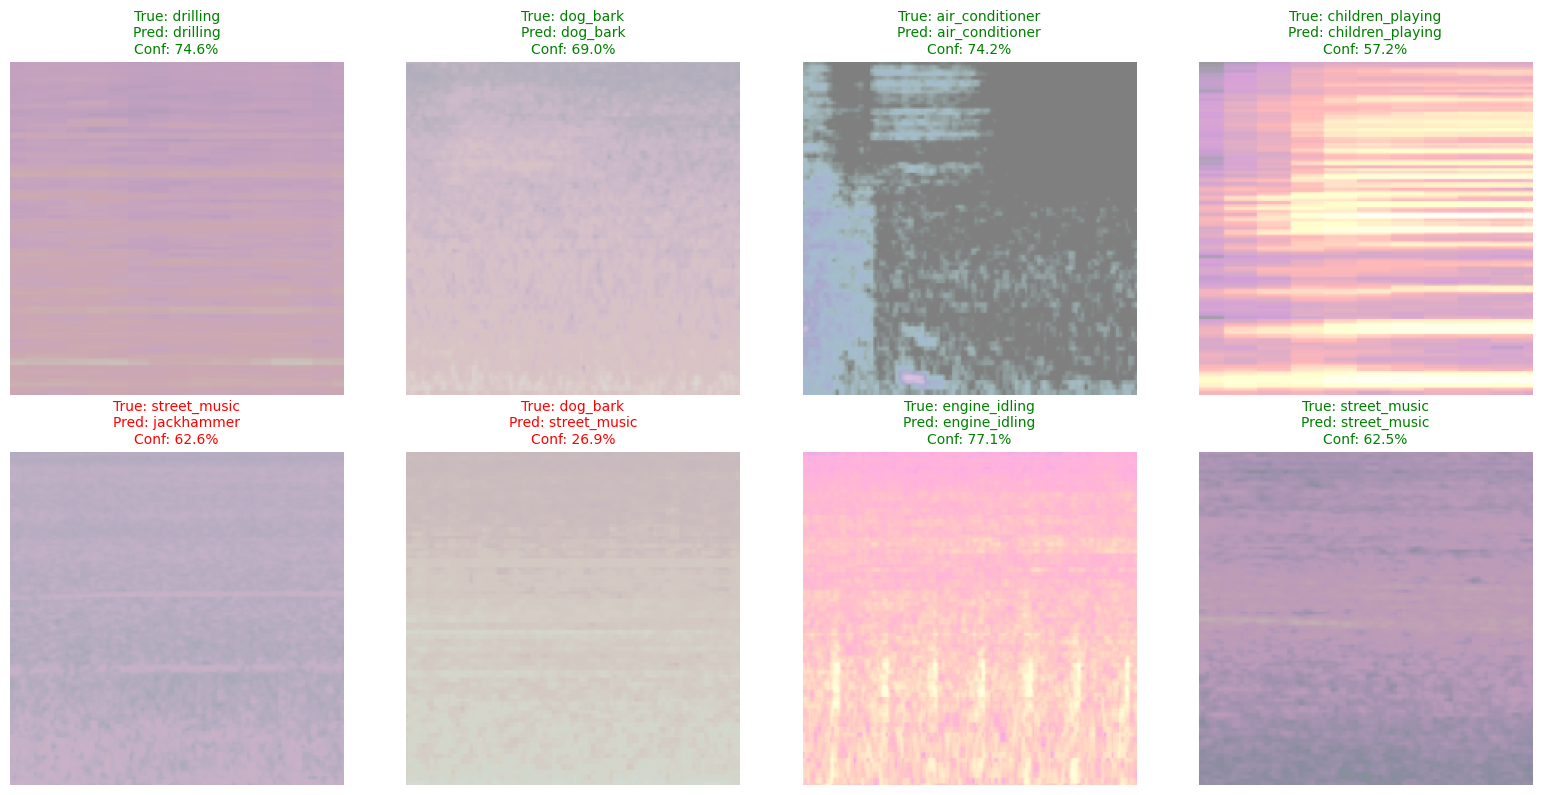


Detailed Predictions:
--------------------------------------------------------------------------------
Sample 1:
  True Label: drilling
  Predicted: drilling
  Confidence: 74.60%
  Status: ✓ Correct
  Top 3 predictions:
    1. drilling: 74.60%
    2. children_playing: 12.45%
    3. street_music: 6.14%

Sample 2:
  True Label: dog_bark
  Predicted: dog_bark
  Confidence: 69.00%
  Status: ✓ Correct
  Top 3 predictions:
    1. dog_bark: 69.00%
    2. gun_shot: 9.00%
    3. engine_idling: 8.09%

Sample 3:
  True Label: air_conditioner
  Predicted: air_conditioner
  Confidence: 74.17%
  Status: ✓ Correct
  Top 3 predictions:
    1. air_conditioner: 74.17%
    2. car_horn: 11.84%
    3. siren: 5.96%

Sample 4:
  True Label: children_playing
  Predicted: children_playing
  Confidence: 57.20%
  Status: ✓ Correct
  Top 3 predictions:
    1. children_playing: 57.20%
    2. drilling: 29.58%
    3. jackhammer: 12.10%

Sample 5:
  True Label: street_music
  Predicted: jackhammer
  Confidence: 62.5

In [10]:
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd

# Load the CSV to get class names
df = pd.read_csv(csv_file)
class_names = df['class'].unique()

# Load the trained model from a specific fold (e.g., fold 1)
fold_to_test = 1
checkpoint = torch.load(f'simclr_classifier_urbansound8k_fold{fold_to_test}.pth')
simclr_model.load_state_dict(checkpoint['simclr_model'])
classifier.load_state_dict(checkpoint['classifier'])
simclr_model.eval()
classifier.eval()

# Get some test samples
test_dataset = UrbanSoundDataset(root_dir=root_dir, fold=fold_to_test, csv_file=csv_file, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Get one batch of test data
dataiter = iter(test_loader)
xi, xj, labels = next(dataiter)
xi, labels = xi.to(device), labels.to(device)

# Make predictions
with torch.no_grad():
    features = simclr_model.backbone(xi)
    outputs = classifier(features)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    _, predictions = torch.max(outputs, 1)

# Display predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx in range(min(8, len(xi))):
    # Convert tensor to image
    img = xi[idx].cpu().numpy().transpose(1, 2, 0)
    # Denormalize if needed
    img = (img * 0.5) + 0.5  # Reverse normalization
    img = np.clip(img, 0, 1)
    
    axes[idx].imshow(img)
    axes[idx].axis('off')
    
    true_label = class_names[labels[idx].item()]
    pred_label = class_names[predictions[idx].item()]
    confidence = probabilities[idx][predictions[idx]].item() * 100
    
    color = 'green' if predictions[idx] == labels[idx] else 'red'
    axes[idx].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%', 
                        color=color, fontsize=10)

plt.tight_layout()
plt.show()

# Print detailed predictions
print("\nDetailed Predictions:")
print("-" * 80)
for idx in range(min(8, len(xi))):
    true_label = class_names[labels[idx].item()]
    pred_label = class_names[predictions[idx].item()]
    confidence = probabilities[idx][predictions[idx]].item() * 100
    
    print(f"Sample {idx+1}:")
    print(f"  True Label: {true_label}")
    print(f"  Predicted: {pred_label}")
    print(f"  Confidence: {confidence:.2f}%")
    print(f"  Status: {'✓ Correct' if predictions[idx] == labels[idx] else '✗ Wrong'}")
    print(f"  Top 3 predictions:")
    top3_probs, top3_indices = torch.topk(probabilities[idx], 3)
    for i, (prob, idx_class) in enumerate(zip(top3_probs, top3_indices)):
        print(f"    {i+1}. {class_names[idx_class.item()]}: {prob.item()*100:.2f}%")
    print()

In [6]:
import timm
from timm.models.vision_transformer import VisionTransformer
import torch
import torchvision.models as models
import numpy as np
import pandas as pd
# BYOL: Bootstrap Your Own Latent
# Self-supervised learning without negative pairs
# BYOL uses an online network and a target network with exponential moving average updates

class BYOLMLPHead(torch.nn.Module):
    """
    Multi-layer perceptron head for BYOL
    """
    def __init__(self, input_dim, hidden_dim=4096, output_dim=256):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.relu = torch.nn.ReLU(inplace=True)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


class BYOLPredictor(torch.nn.Module):
    """
    Predictor head used only in the online network of BYOL
    """
    def __init__(self, input_dim=256, hidden_dim=4096, output_dim=256):
        super().__init__()
        self.fc1 = torch.nn.Linear(input_dim, hidden_dim)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.relu = torch.nn.ReLU(inplace=True)
        self.fc2 = torch.nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


class BYOL(torch.nn.Module):
    """
    BYOL (Bootstrap Your Own Latent) model
    Consists of online network (with predictor) and target network (updated via EMA)
    """
    def __init__(self, backbone, projection_head_dim=256, hidden_dim=4096):
        super().__init__()
        
        # Online network: backbone + projection head + predictor
        self.online_backbone = backbone
        backbone_dim = backbone.fc.in_features if hasattr(backbone.fc, 'in_features') else 2048
        
        self.online_projection = BYOLMLPHead(backbone_dim, hidden_dim=hidden_dim, output_dim=projection_head_dim)
        self.online_predictor = BYOLPredictor(projection_head_dim, hidden_dim=hidden_dim, output_dim=projection_head_dim)
        
        # Target network: same as online but without predictor, updated via EMA
        self.target_backbone = self._build_target_backbone(backbone)
        self.target_projection = BYOLMLPHead(backbone_dim, hidden_dim=hidden_dim, output_dim=projection_head_dim)
        
        # Freeze target network
        self._freeze_target_network()
        
    def _build_target_backbone(self, backbone):
        """Create a copy of the backbone for the target network"""
        import copy
        return copy.deepcopy(backbone)
    
    def _freeze_target_network(self):
        """Freeze target network parameters"""
        for param in self.target_backbone.parameters():
            param.requires_grad = False
        for param in self.target_projection.parameters():
            param.requires_grad = False
    
    def forward(self, x1, x2):
        """
        Forward pass through online and target networks
        Args:
            x1, x2: Two augmented views of the same image
        Returns:
            online_pred: Predictions from online network
            target_proj: Projections from target network (detached)
        """
        # Online network
        online_feat = self.online_backbone(x1)
        online_proj = self.online_projection(online_feat)
        online_pred = self.online_predictor(online_proj)
        
        # Target network (no gradients)
        with torch.no_grad():
            target_feat = self.target_backbone(x2)
            target_proj = self.target_projection(target_feat)
        
        return online_pred, target_proj, online_feat


# Initialize ResNet backbone for BYOL
byol_backbone = models.resnet50(pretrained=True)
byol_backbone.fc = torch.nn.Identity()

# Create BYOL model
byol_model = BYOL(byol_backbone, projection_head_dim=256, hidden_dim=4096).to(device)

print("BYOL model created successfully")
print(f"Device: {device}")



BYOL model created successfully
Device: cuda


In [7]:
class BYOLLoss(torch.nn.Module):
    """
    BYOL loss: Mean Squared Error between online predictions and target projections
    Uses stop-gradient on target projections to prevent collapse
    """
    def __init__(self):
        super().__init__()
    
    def forward(self, online_pred, target_proj):
        """
        Args:
            online_pred: Predictions from online network (B, D)
            target_proj: Projections from target network (B, D), detached
        Returns:
            loss: MSE loss between online predictions and target projections
        """
        # Normalize predictions and projections
        online_pred_norm = torch.nn.functional.normalize(online_pred, dim=-1, p=2)
        target_proj_norm = torch.nn.functional.normalize(target_proj, dim=-1, p=2)
        
        # MSE loss
        loss = 2 - 2 * torch.mean(torch.sum(online_pred_norm * target_proj_norm, dim=-1))
        
        return loss


def update_target_network_ema(online_network, target_network, tau=0.999):
    """
    Update target network using exponential moving average (EMA)
    This is the key mechanism in BYOL that prevents collapse without negative pairs
    
    Args:
        online_network: Online network parameters
        target_network: Target network parameters to be updated
        tau: EMA momentum (default: 0.999)
    """
    for online_param, target_param in zip(online_network.parameters(), target_network.parameters()):
        target_param.data = target_param.data * tau + online_param.data * (1 - tau)


def extract_byol_features(byol_model, dataloader, device):
    """
    Extract features from all samples using trained BYOL online backbone
    """
    features_list = []
    labels_list = []
    
    byol_model.online_backbone.eval()
    
    with torch.no_grad():
        for batch in dataloader:
            if isinstance(batch, (tuple, list)) and len(batch) >= 2:
                images = batch[0]
                labels = batch[-1]
            else:
                images = batch
                labels = None
            
            images = images.to(device)
            features = byol_model.online_backbone(images)
            
            features_list.append(features.cpu())
            if labels is not None:
                labels_list.append(labels.cpu())
    
    all_features = torch.cat(features_list, dim=0)
    all_labels = torch.cat(labels_list, dim=0) if labels_list else None
    
    return all_features, all_labels


# Initialize BYOL loss
byol_loss_fn = BYOLLoss().to(device)

print("BYOL loss and utilities initialized")


BYOL loss and utilities initialized


In [17]:
# BYOL Training Loop


root_dir = '/kaggle/input/urbansound8k-mel-spectrogram-images/archive/'

csv_file = "/kaggle/input/urbansound8k-mel-spectrogram-images/archive/UrbanSound8K.csv"



byol_num_epochs = 10
byol_batch_size = 32
byol_learning_rate = 0.0003
ema_tau = 0.999
byol_weight_decay = 1e-6

# Optimizer for online network only (target network is updated via EMA)
byol_optimizer = torch.optim.Adam(byol_model.online_backbone.parameters(), 
                                   lr=byol_learning_rate, weight_decay=byol_weight_decay)
byol_optimizer_proj = torch.optim.Adam(list(byol_model.online_projection.parameters()) + 
                                        list(byol_model.online_predictor.parameters()),
                                        lr=byol_learning_rate, weight_decay=byol_weight_decay)

byol_train_losses = []
byol_val_accuracies = []

# Training BYOL on UrbanSound8K
for fold in range(1, 10):  # Train on fold 1 as example
    print(f"\n{'='*60}")
    print(f"Training BYOL on fold {fold}")
    print(f"{'='*60}")
    
    train_dataset = UrbanSoundDataset(root_dir=root_dir, fold=fold, csv_file=csv_file, transform=transform)
    val_dataset = UrbanSoundDataset(root_dir=root_dir, fold=fold, csv_file=csv_file, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=byol_batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=byol_batch_size, shuffle=False)
    
    # Create a classifier head on top of BYOL features for downstream task
    byol_classifier = Classifier(feature_dim=2048, num_classes=num_classes).to(device)
    byol_classifier_optimizer = torch.optim.Adam(byol_classifier.parameters(), lr=0.001)
    
    for epoch in range(byol_num_epochs):
        byol_model.online_backbone.train()
        byol_model.online_projection.train()
        byol_model.online_predictor.train()
        byol_classifier.train()
        
        epoch_loss = 0
        
        for batch_idx, (xi, xj, labels) in enumerate(train_loader):
            xi, xj, labels = xi.to(device), xj.to(device), labels.to(device)
            
            # Forward pass through BYOL
            online_pred, target_proj, online_feat = byol_model(xi, xj)
            
            # Compute BYOL loss
            loss_byol = byol_loss_fn(online_pred, target_proj)
            
            # Also compute loss with swapped views (symmetric loss)
            online_pred_swap, target_proj_swap, _ = byol_model(xj, xi)
            loss_byol_swap = byol_loss_fn(online_pred_swap, target_proj_swap)
            
            # Combined BYOL loss
            loss_byol_combined = (loss_byol + loss_byol_swap) / 2
            
            # Classifier loss for downstream task
            classifier_out = byol_classifier(online_feat.detach())
            loss_classifier = torch.nn.functional.cross_entropy(classifier_out, labels)
            
            # Total loss
            loss = loss_byol_combined + loss_classifier
            
            byol_optimizer.zero_grad()
            byol_optimizer_proj.zero_grad()
            byol_classifier_optimizer.zero_grad()
            loss.backward()
            byol_optimizer.step()
            byol_optimizer_proj.step()
            byol_classifier_optimizer.step()
            
            # Update target network using EMA
            update_target_network_ema(byol_model.online_backbone, byol_model.target_backbone, ema_tau)
            update_target_network_ema(byol_model.online_projection, byol_model.target_projection, ema_tau)
            
            epoch_loss += loss.item()
            
            if (batch_idx + 1) % max(1, len(train_loader) // 4) == 0:
                print(f"Epoch [{epoch+1}/{byol_num_epochs}], Step [{batch_idx+1}/{len(train_loader)}], "
                      f"BYOL Loss: {loss_byol_combined.item():.4f}, Total Loss: {loss.item():.4f}")
        
        avg_train_loss = epoch_loss / len(train_loader)
        byol_train_losses.append(avg_train_loss)
        print(f"\nEpoch [{epoch+1}/{byol_num_epochs}] - Average Training Loss: {avg_train_loss:.4f}")
        
        # Validation
        byol_model.online_backbone.eval()
        byol_classifier.eval()
        val_correct = 0
        val_total = 0
        
        with torch.no_grad():
            for xi, xj, labels in val_loader:
                xi, labels = xi.to(device), labels.to(device)
                
                # Extract features using online backbone
                features = byol_model.online_backbone(xi)
                outputs = byol_classifier(features)
                
                _, predicted = torch.max(outputs, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
        
        val_accuracy = 100 * val_correct / val_total
        byol_val_accuracies.append(val_accuracy)
        print(f"Validation Accuracy: {val_accuracy:.2f}%\n")
    
    # Save BYOL model
    torch.save({
        'online_backbone': byol_model.online_backbone.state_dict(),
        'online_projection': byol_model.online_projection.state_dict(),
        'online_predictor': byol_model.online_predictor.state_dict(),
        'target_backbone': byol_model.target_backbone.state_dict(),
        'target_projection': byol_model.target_projection.state_dict(),
        'classifier': byol_classifier.state_dict(),
    }, f'byol_urbansound8k_fold{fold}.pth')
    
    print(f"BYOL model saved as byol_urbansound8k_fold{fold}.pth")

print(f"\nBYOL training completed!")



Training BYOL on fold 1
Epoch [1/10], Step [7/28], BYOL Loss: 0.5981, Total Loss: 2.0573
Epoch [1/10], Step [14/28], BYOL Loss: 0.5700, Total Loss: 2.2025
Epoch [1/10], Step [21/28], BYOL Loss: 0.5119, Total Loss: 1.7336
Epoch [1/10], Step [28/28], BYOL Loss: 0.4749, Total Loss: 1.7731

Epoch [1/10] - Average Training Loss: 1.9946
Validation Accuracy: 60.94%

Epoch [2/10], Step [7/28], BYOL Loss: 0.4756, Total Loss: 1.7973
Epoch [2/10], Step [14/28], BYOL Loss: 0.4582, Total Loss: 1.4787
Epoch [2/10], Step [21/28], BYOL Loss: 0.4514, Total Loss: 1.3389
Epoch [2/10], Step [28/28], BYOL Loss: 0.5957, Total Loss: 3.0768

Epoch [2/10] - Average Training Loss: 1.6500
Validation Accuracy: 63.92%

Epoch [3/10], Step [7/28], BYOL Loss: 0.4231, Total Loss: 1.1902
Epoch [3/10], Step [14/28], BYOL Loss: 0.4706, Total Loss: 1.5019
Epoch [3/10], Step [21/28], BYOL Loss: 0.4269, Total Loss: 1.2183
Epoch [3/10], Step [28/28], BYOL Loss: 0.6253, Total Loss: 1.9521

Epoch [3/10] - Average Training Los

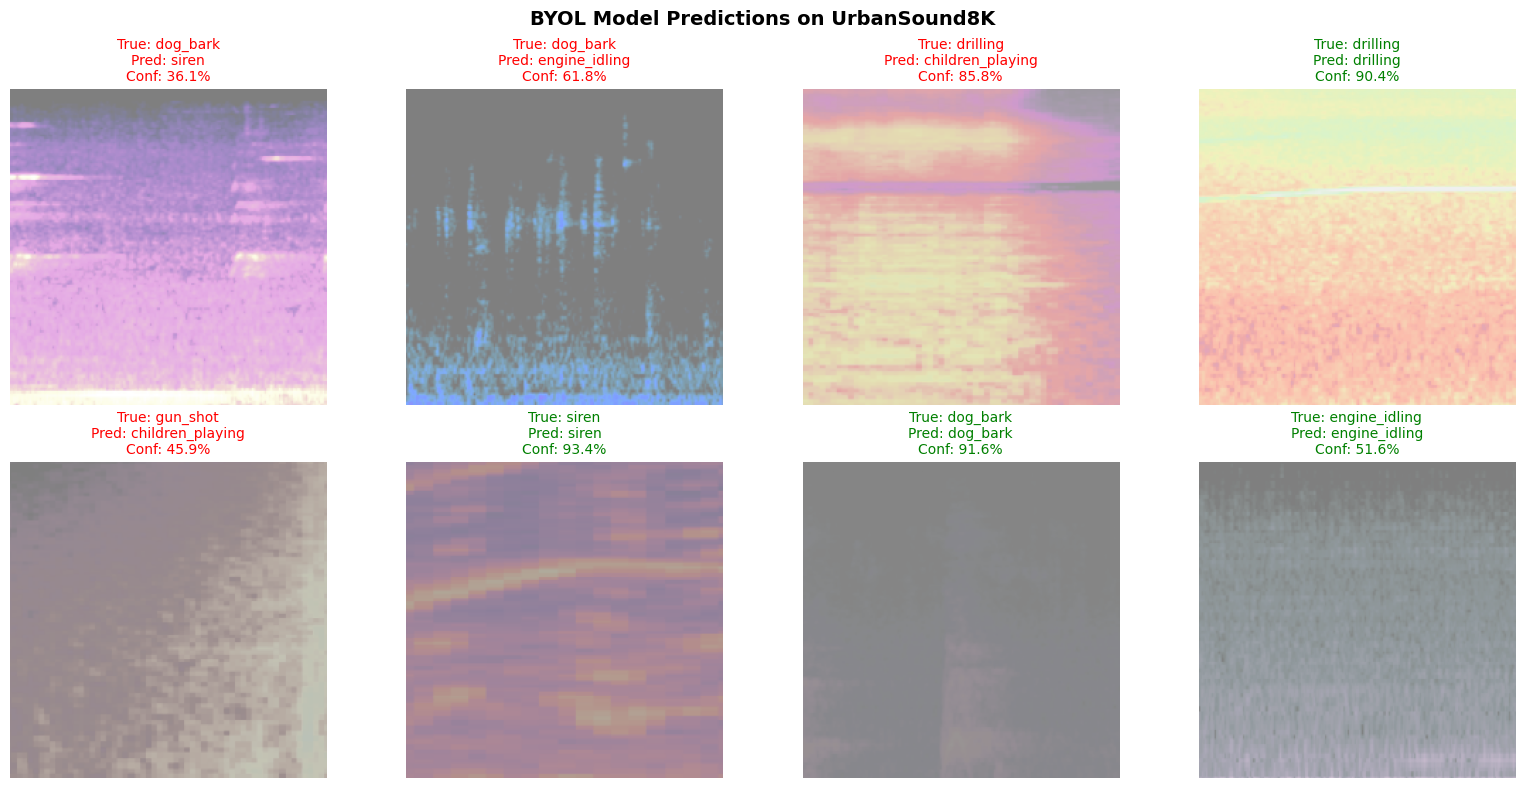


BYOL MODEL EVALUATION RESULTS

Sample 1:
  True Label: dog_bark
  Predicted: siren
  Confidence: 36.08%
  Status: ✗ Wrong
  Top 3 predictions:
    1. siren: 36.08%
    2. dog_bark: 23.96%
    3. children_playing: 16.14%

Sample 2:
  True Label: dog_bark
  Predicted: engine_idling
  Confidence: 61.83%
  Status: ✗ Wrong
  Top 3 predictions:
    1. engine_idling: 61.83%
    2. dog_bark: 16.19%
    3. siren: 10.07%

Sample 3:
  True Label: drilling
  Predicted: children_playing
  Confidence: 85.84%
  Status: ✗ Wrong
  Top 3 predictions:
    1. children_playing: 85.84%
    2. street_music: 8.52%
    3. siren: 3.67%

Sample 4:
  True Label: drilling
  Predicted: drilling
  Confidence: 90.42%
  Status: ✓ Correct
  Top 3 predictions:
    1. drilling: 90.42%
    2. siren: 7.02%
    3. air_conditioner: 1.80%

Sample 5:
  True Label: gun_shot
  Predicted: children_playing
  Confidence: 45.89%
  Status: ✗ Wrong
  Top 3 predictions:
    1. children_playing: 45.89%
    2. dog_bark: 22.93%
    3. si

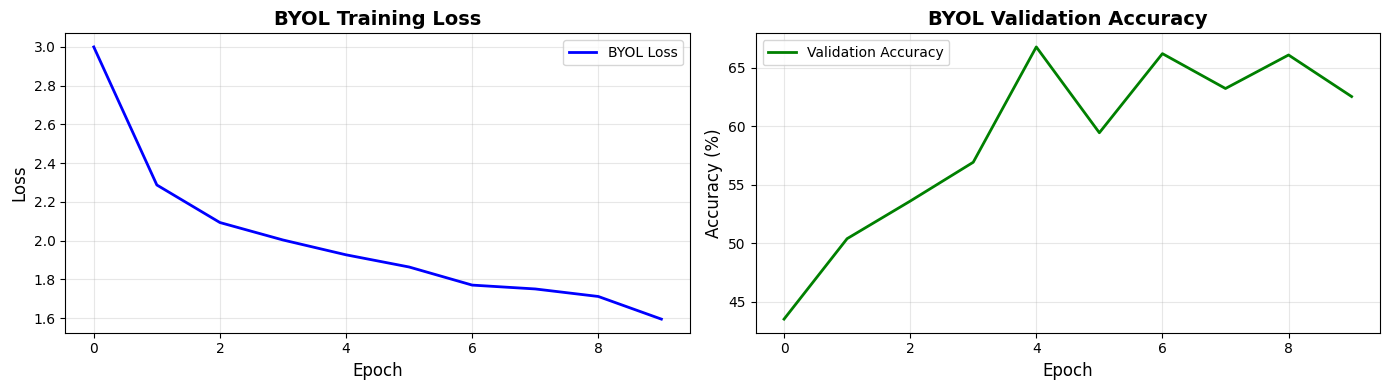


BYOL training and evaluation completed successfully!


In [16]:

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import pandas as pd
# BYOL Evaluation and Visualization

# Load trained BYOL model
fold_to_eval = 1
byol_checkpoint = torch.load(f'byol_urbansound8k_fold{fold_to_eval}.pth')

byol_model.online_backbone.load_state_dict(byol_checkpoint['online_backbone'])
byol_model.online_projection.load_state_dict(byol_checkpoint['online_projection'])
byol_model.online_predictor.load_state_dict(byol_checkpoint['online_predictor'])
byol_classifier.load_state_dict(byol_checkpoint['classifier'])

byol_model.online_backbone.eval()
byol_classifier.eval()

# Get test samples
test_dataset = UrbanSoundDataset(root_dir=root_dir, fold=fold_to_eval, csv_file=csv_file, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=True)

# Get class names
class_mapping = pd.read_csv(csv_file)[['classID', 'class']].drop_duplicates().sort_values('classID')
class_names_byol = class_mapping['class'].values

# Make predictions
dataiter = iter(test_loader)
xi, xj, labels = next(dataiter)
xi, labels = xi.to(device), labels.to(device)

with torch.no_grad():
    features = byol_model.online_backbone(xi)
    outputs = byol_classifier(features)
    probabilities = torch.nn.functional.softmax(outputs, dim=1)
    _, predictions = torch.max(outputs, 1)

# Display BYOL predictions
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.ravel()

for idx in range(min(8, len(xi))):
    # Convert tensor to image
    img = xi[idx].cpu().numpy().transpose(1, 2, 0)
    img = (img * 0.5) + 0.5  # Denormalize
    img = np.clip(img, 0, 1)
    
    axes[idx].imshow(img)
    axes[idx].axis('off')
    
    true_label = class_names_byol[labels[idx].item()]
    pred_label = class_names_byol[predictions[idx].item()]
    confidence = probabilities[idx][predictions[idx]].item() * 100
    
    color = 'green' if predictions[idx] == labels[idx] else 'red'
    axes[idx].set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {confidence:.1f}%', 
                        color=color, fontsize=10)

plt.suptitle('BYOL Model Predictions on UrbanSound8K', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Print detailed BYOL evaluation
print("\n" + "="*80)
print("BYOL MODEL EVALUATION RESULTS")
print("="*80)

for idx in range(min(8, len(xi))):
    true_label = class_names_byol[labels[idx].item()]
    pred_label = class_names_byol[predictions[idx].item()]
    confidence = probabilities[idx][predictions[idx]].item() * 100
    
    print(f"\nSample {idx+1}:")
    print(f"  True Label: {true_label}")
    print(f"  Predicted: {pred_label}")
    print(f"  Confidence: {confidence:.2f}%")
    print(f"  Status: {'✓ Correct' if predictions[idx] == labels[idx] else '✗ Wrong'}")
    print(f"  Top 3 predictions:")
    top3_probs, top3_indices = torch.topk(probabilities[idx], 3)
    for i, (prob, idx_class) in enumerate(zip(top3_probs, top3_indices)):
        print(f"    {i+1}. {class_names_byol[idx_class.item()]}: {prob.item()*100:.2f}%")

# Plot BYOL training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))

# Training loss
ax1.plot(range(len(byol_train_losses)), byol_train_losses, 'b-', linewidth=2, label='BYOL Loss')
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Loss', fontsize=12)
ax1.set_title('BYOL Training Loss', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend(fontsize=10)

# Validation accuracy
ax2.plot(range(len(byol_val_accuracies)), byol_val_accuracies, 'g-', linewidth=2, label='Validation Accuracy')
ax2.set_xlabel('Epoch', fontsize=12)
ax2.set_ylabel('Accuracy (%)', fontsize=12)
ax2.set_title('BYOL Validation Accuracy', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend(fontsize=10)

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("BYOL training and evaluation completed successfully!")
print("="*80)
